# Binary Classification on Tabular Data - Predicting Abnormal ECG Scans





## Introduction

In this example, you will train an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5,000 Electrocardiograms, each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

## Technical preliminaries


In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the 
# results will be the same every time the notebook is run
tf.random.set_seed(42)

pd.options.mode.chained_assignment = None

## Read in the data

Conveniently, the dataset in CSV form has been made available online and we can load it into a Pandas dataframe with the very useful `pd.read_csv` command.

In [10]:
#Because each column of data represents a datapoint we will name the columns by the sequence of datapoints 
# (1,2,3...140)
names = []
for i in range(140):
    names.append(i)
# The last column will be the target or dependent variable
names.append('Target')


#### Read in the data from http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv and set the column names from the list created in the box above

In [11]:
df = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv",names=names, header=None)

In [12]:
df.shape

(4998, 141)

##### The dataset has 4998 rows and 141 columns (140 independent variables + 1 dependent variable):

##### Let's take a look at the first few rows:

In [13]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,Target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## Preprocessing 

This dataset only has numeric variables. For concistancy sake, we will assign the column names to variable numerics. 


In [14]:
numerics = names

# Remove the dependent variable
numerics.remove('Target') 

What % of the data is abnormal data?

In [52]:
# Set the output to "target_metrics"
df.target.value_counts(normalize=True)

0          1          2          3          4          5          6          7          8          9          10         11         12         13         14         15         16         17         18         19         20         21         22         23         24         25         26         27         28         29         30         31         32         33         34         35         36         37         38         39         40         41         42         43         44         45         46         47         48         49         50         51         52         53         54         55         56        57         58         59         60         61         62         63         64         65         66         67         68         69         70         71         72         73         74         75         76         77         78         79         80         81         82         83         84         85         86         87         88         89         90         

###### Extract the dependent variable 

In [15]:
#set the dependent variables to 'y'
# YOUR CODE HERE
y = df.pop('Target')


Before we normalize the numerics, let's split the data into an 80% training set and 20% test set (*why should we split **before** normalization?*).

In [22]:
from sklearn.model_selection import train_test_split

In [31]:
#split into train and test sets with the following naming conventions:
# X_train, X_test, y_train and y_test
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y)

OK, let's calculate the mean and standard deviation of every numeric variable in the training set.

In [32]:
# Assign the means to "means" and standard deviation to "sd"
# YOUR CODE HERE
means = X_train[numerics].mean()
sd = X_train[numerics].std()
print(means)

0     -0.266272
1     -1.656148
2     -2.491521
3     -3.116148
4     -3.165190
         ...   
135   -0.753263
136   -0.834143
137   -0.649643
138   -0.495841
139   -0.706733
Length: 140, dtype: float64


Let's normalize the train and test dataframes with these means and standard deviations.

In [33]:
# Normalize X_train
# YOUR CODE HERE
X_train[numerics]= (X_train[numerics] - means)/sd

In [34]:
# Normalize X_test
# YOUR CODE HERE
X_test[numerics]= (X_test[numerics] - means)/sd

In [35]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
109,0.234240,-0.606194,-0.793758,-0.677814,-0.711217,-0.682509,-0.237022,0.114410,-0.238920,0.215500,...,0.639955,0.703646,0.838614,0.963435,0.923231,0.849427,0.850153,1.079338,1.141794,-0.144848
3271,0.929983,0.990473,0.772293,0.727899,0.410103,-0.180147,-0.912341,-1.255321,-0.925450,-0.466601,...,-0.795505,-0.971832,-1.111569,-1.043015,-1.203568,-1.374501,-1.541881,-1.575045,-1.235526,-0.619135
86,-0.097490,-0.316664,-0.613557,-1.154483,-1.311212,-1.182995,-0.295024,0.752413,0.234129,0.435326,...,0.450871,0.190226,0.317921,0.310176,0.508510,0.566449,0.595167,0.745489,0.746913,0.294486
334,0.390038,1.065637,1.393303,1.569175,1.676994,1.474851,0.634905,-0.420320,-1.069522,-1.379238,...,-1.474843,-1.480634,-1.483358,-1.473156,-1.461050,-1.557800,-1.567390,-1.452567,-1.154197,-0.273973
782,1.797675,2.368658,1.709050,0.941413,-0.089237,-1.611380,-1.916820,-1.005544,-0.408834,-0.841417,...,-0.129335,0.079579,0.578229,0.597970,0.931259,1.389311,1.537302,1.567299,0.959203,1.762194


The easiest way to feed data to Keras/Tensorflow is as Numpy arrays so we convert our two dataframes to Numpy arrays.

In [36]:
# Convert X_train and X_test to Numpy arrays
# YOUR CODE HERE
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [37]:
# If this box fails on a second attempt try recreating X_train and X_test and running the boxes before this. 

In [38]:
X_train.shape, y_train.shape

((3998, 140), (3998,))

In [39]:
X_test.shape, y_test.shape


((1000, 140), (1000,))

## Build a model



### Define model in Keras

Creating an NN  is usually just a few lines of Keras code. 

* We will start with a single hidden layer. 
* Since this is a *binary classification problem*, we will use a sigmoid activation in the output layer.

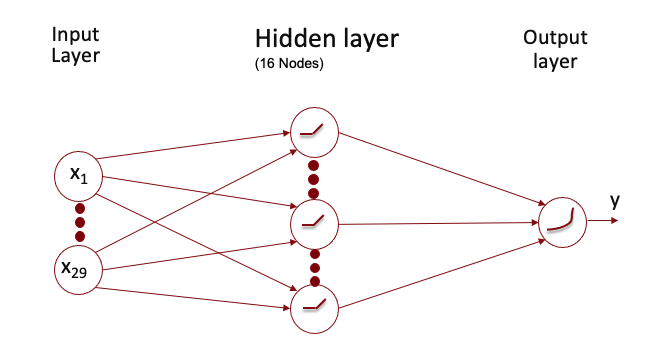

In [40]:
#get the number of columns and assign it to "num_columns"

# YOUR CODE HERE
num_columns = X_train.shape[1]

# Define the input layer. assign it to "input"
# YOUR CODE HERE
input = keras.Input(shape=num_columns)

# Feed the input vector to the hidden layer. Call it "h"
# YOUR CODE HERE
h = keras.layers.Dense(16, activation="relu", name="Hidden")(input)

# Feed the output of the hidden layer to the output layer. Call it "output"
# YOUR CODE HERE
output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)

# tell Keras that this (input,output) pair is your model. Call it "model"
# YOUR CODE HERE
model = keras.Model(input, output)

The `model.summary()` command is a good way to get a quick overview of what you have defined.

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
Hidden (Dense)               (None, 16)                2256      
_________________________________________________________________
Output (Dense)               (None, 1)                 17        
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________


We can "visualize" the network graphically as well using Keras' `plot_model` function.

In [42]:
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Set optimization parameters

Now that the model is defined, we need to tell Keras three things:

*   What **loss function** to use - Since our output variable is binary, we will select the `binary_crossentropy` loss function. 
*   Which **optimizer** to use - we will use a 'flavor' of SGD called **Adam** which is an excellent default choice 
*   What **metrics** you want Keras to report out - in classification problems like this one, Accuracy is commonly used.

In [43]:
# YOUR CODE HERE
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

## Train the model

To kickoff training, we have to decide on three things:
* The *batch size* - 32 is a good default
* The number of *epochs* i.e., how many passes through the training data. Start by setting this to 100, but you can experiment with different values.
* Whether we want to use a validation set. This will be useful for overfitting detection and regularization via early stopping so we will ask Keras to automatically use 20% of the data points as a validation set

OK, let's train the model using the `model.fit` function!

In [48]:
# Fit your model and assign the output to "history"
# YOUR CODE HERE
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
100/100 [==============================] - 0s 2ms/step - loss: 5.2693e-04 - accuracy: 1.0000 - val_loss: 0.1500 - val_accuracy: 0.9800
Epoch 2/10
100/100 [==============================] - 0s 2ms/step - loss: 5.1540e-04 - accuracy: 1.0000 - val_loss: 0.1593 - val_accuracy: 0.9812
Epoch 3/10
100/100 [==============================] - 0s 2ms/step - loss: 5.2018e-04 - accuracy: 1.0000 - val_loss: 0.1579 - val_accuracy: 0.9812
Epoch 4/10
100/100 [==============================] - 0s 2ms/step - loss: 5.1743e-04 - accuracy: 1.0000 - val_loss: 0.1588 - val_accuracy: 0.9812
Epoch 5/10
100/100 [==============================] - 0s 2ms/step - loss: 4.9880e-04 - accuracy: 1.0000 - val_loss: 0.1556 - val_accuracy: 0.9812
Epoch 6/10
100/100 [==============================] - 0s 2ms/step - loss: 3.7614e-04 - accuracy: 1.0000 - val_loss: 0.1608 - val_accuracy: 0.9812
Epoch 7/10
100/100 [==============================] - 0s 2ms/step - loss: 3.7151e-04 - accuracy: 1.0000 - val_loss: 0.1614 -

Let's plot the training and loss curves to see if ***overfitting*** is going on and if **early stopping** may be needed.

In [49]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

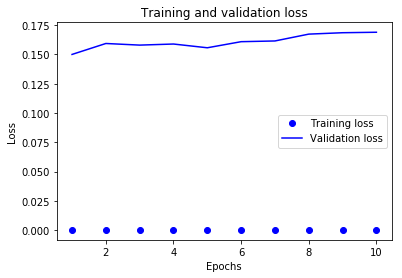

In [50]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


Let's look at the accuracy curves as well.



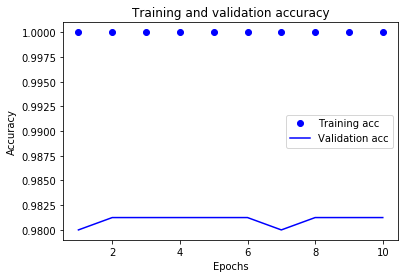

In [51]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Do you think there's overfitting?**

If you think there's overfitting at epoch N, we could go back, re-initialize the model and just run it for  N epochs - that would an example of **early stopping**.

I invite you to try exactly that and compare to the test set accuracy calculated below. Perhaps you can do better!

## Evaluate the model

Let's see **how well the model does on the test set**. 

`model.evaluate` is a very handy function to calculate the performance of your model on any dataset.

In [52]:
# Getting the results of your model for grading
score, acc = model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0523 - accuracy: 0.9940


In [53]:
### This box will pass if your accuracy is over 97%

To assess if this accuracy number is impressive, we can compare it the accuracy of a simple, baseline model. 

What's a reasonable baseline model?

In [54]:
y.value_counts(normalize=True)

1.0    0.584034
0.0    0.415966
Name: Target, dtype: float64

If we predict 0 for every point, the accuracy will be 41.6%. So the 98.2% accuracy from our DL model is excellent!!
